In [1]:
# -*- coding: utf-8 -*- #

# Write libraries here #########################################
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from astroquery.gama import GAMA
from jupyterthemes import jtplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, cluster, preprocessing, mixture
from time import time
from tqdm import tnrange, tqdm_notebook
%matplotlib inline
################################################################


# Showing 500 columns and rows #################################
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
################################################################


# NOT CHANGE (The PATH for directory) ##########################
CURRENT_DIR_NAME = os.path.dirname(os.path.abspath(__name__))
PATH_DATA = os.path.join(CURRENT_DIR_NAME, '../data/')
PATH_HIST = os.path.join(CURRENT_DIR_NAME, '../histogram/')
PATH_PLOT = os.path.join(CURRENT_DIR_NAME, '../plots/')
PATH_IMG = os.path.join(CURRENT_DIR_NAME, '../images/')
PATH_HTML = os.path.join(CURRENT_DIR_NAME, '../html/')
PATH_TEX = os.path.join(CURRENT_DIR_NAME, '../for_tex/')
################################################################

#When you make plots, jtplot is better.
jtplot.style(theme='grade3', context='notebook', fscale=3, spines=True, gridlines='--', ticks=False, grid=False)

Error initializing plugin EntryPoint('Gnome', 'keyrings.alt.Gnome', None, Distribution('keyrings.alt', '1.3')).
Traceback (most recent call last):
  File "/home/syoshida/.local/lib/python3.5/site-packages/keyring/backend.py", line 188, in _load_plugins
    init_func = ep.load()
  File "/home/syoshida/.local/lib/python3.5/site-packages/entrypoints.py", line 82, in load
    mod = import_module(self.module_name)
  File "/usr/lib/python3.5/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 986, in _gcd_import
  File "<frozen importlib._bootstrap>", line 969, in _find_and_load
  File "<frozen importlib._bootstrap>", line 958, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 673, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 673, in exec_module
  File "<frozen importlib._bootstrap>", line 222, in _call_with_frames_removed
  File "/usr/l

In [2]:
# Read the data

DATA_GAMA_KCORRECTED = GAMA.query_sql('SELECT * FROM kcorr_auto_z00 LIMIT 1000000')
#DATA_GAMA_MAGPHYS = GAMA.query_sql('SELECT * FROM MagPhys LIMIT 1000000')
DATA_GAMA_FLUX = GAMA.query_sql('SELECT * FROM LambdarCat LIMIT 1000000')
#DATA_GAMA_REDSHIFT = GAMA.query_sql('SELECT * FROM AATRunzResults LIMIT 1000000')

In [3]:
# Arrange the Astropy table for the analysis (Convert into pd.DataFrame, set index and select samples which have reliable redshift)
DATA_GAMA_FLUX = DATA_GAMA_FLUX.to_pandas().set_index('CATAID')
DATA_GAMA_KCORRECTED = DATA_GAMA_KCORRECTED.to_pandas().set_index('CATAID').loc[DATA_GAMA_KCORRECTED['NQ'] >= 3]
DATA_GAMA_FLUX = DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['FUV_flux'] > 0) & (DATA_GAMA_FLUX['NUV_flux'] > 0) &
                                    (DATA_GAMA_FLUX['u_flux'] > 0) & (DATA_GAMA_FLUX['g_flux'] > 0) & (DATA_GAMA_FLUX['r_flux'] > 0) & (DATA_GAMA_FLUX['i_flux'] > 0) & (DATA_GAMA_FLUX['z_flux'] > 0) & 
                                    (DATA_GAMA_FLUX['Y_flux'] > 0) & (DATA_GAMA_FLUX['J_flux'] > 0) & (DATA_GAMA_FLUX['H_flux'] > 0) & (DATA_GAMA_FLUX['K_flux'] > 0)].join(DATA_GAMA_KCORRECTED, how='inner')
DATA_GAMA_FLUX['FUV_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['FUV_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_FUV']
DATA_GAMA_FLUX['NUV_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['NUV_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_NUV']
DATA_GAMA_FLUX['U_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['u_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_U']
DATA_GAMA_FLUX['G_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['g_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_G']
DATA_GAMA_FLUX['R_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['r_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_R']
DATA_GAMA_FLUX['I_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['i_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_I']
DATA_GAMA_FLUX['Z_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['z_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_Z']
DATA_GAMA_FLUX['Y_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['Y_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_Y']
DATA_GAMA_FLUX['J_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['J_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_J']
DATA_GAMA_FLUX['H_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['H_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_H']
DATA_GAMA_FLUX['K_flux_kcorrected'] = -2.5 * np.log10(DATA_GAMA_FLUX['K_flux']) + 8.90 + DATA_GAMA_FLUX['KCORR_K']
DATA_GAMA_FLUX['R-K'] = DATA_GAMA_FLUX['R_flux_kcorrected'] - DATA_GAMA_FLUX['K_flux_kcorrected']
DATA_GAMA_FLUX['NUV-R'] = DATA_GAMA_FLUX['NUV_flux_kcorrected'] - DATA_GAMA_FLUX['R_flux_kcorrected']
DATA_GAMA_FLUX = DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['NUV_flux_kcorrected'] < 23.5) & (DATA_GAMA_FLUX['I_flux_kcorrected'] < 22.5)]
# Show the details of our samples for manifold learning
display(DATA_GAMA_FLUX.describe())

,RA,DEC,FUV_flux,FUV_fluxerr,NUV_flux,NUV_fluxerr,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,X_flux,X_fluxerr,Y_flux,Y_fluxerr,J_flux,J_fluxerr,H_flux,H_fluxerr,K_flux,K_fluxerr,W1_flux,W1_fluxerr,W2_flux,W2_fluxerr,W3_flux,W3_fluxerr,W4_flux,W4_fluxerr,P100_flux,P100_fluxerr,P160_flux,P160_fluxerr,S250_flux,S250_fluxerr,S350_flux,S350_fluxerr,S500_flux,S500_fluxerr,Z_TONRY,NQ,KCORR_FUV,KCORR_NUV,KCORR_U,KCORR_G,KCORR_R,KCORR_I,KCORR_Z,KCORR_Y,KCORR_J,KCORR_H,KCORR_K,PCOEFF_R_1,PCOEFF_R_2,PCOEFF_R_3,PCOEFF_R_4,PCOEFF_R_5,COEFFS_1,COEFFS_2,COEFFS_3,COEFFS_4,COEFFS_5,CHI2,MASS,INTSFH,METS,B300,B1000,FUV_flux_kcorrected,NUV_flux_kcorrected,U_flux_kcorrected,G_flux_kcorrected,R_flux_kcorrected,I_flux_kcorrected,Z_flux_kcorrected,Y_flux_kcorrected,J_flux_kcorrected,H_flux_kcorrected,K_flux_kcorrected,R-K,NUV-R
count,66559.000000,66559.000000,6.655900e+04,6.655900e+04,66559.000000,6.655900e+04,6.655900e+04,6.655900e+04,6.655900e+04,6.655900e+04,66559.000000,6.655900e+04,66559.000000,6.655900e+04,6.655900e+04,66559.000000,66559.000000,66559.000000,6.655900e+04,66559.000000,6.655900e+04,66559.000000,6.655900e+04,66559.000000,6.655900e+04,66559.000000,66559.000000,66559.000000,6.655900e+04,66559.000000,66559.000000,66559.000000,6.655900e+04,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,6.655900e+04,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,6.655900e+04,6.655900e+04,6.655900e+04,6.655900e+04,6.655900e+04,66559.000000,6.655900e+04,6.655900e+04,66559.000000,6.655900e+04,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000,66559.000000
mean,191.456951,0.364917,1.091681e-05,1.501174e-06,0.000020,7.166551e-06,4.358378e-05,6.014312e-06,1.331207e-04,6.923607e-06,0.000253,9.512922e-06,0.000358,1.296484e-05,4.350806e-04,0.000028,-5.342854,-5.343269,5.252707e-04,0.000037,6.145115e-04,0.000033,7.471807e-04,0.000038,7.523481e-04,0.000039,0.000401,0.000068,2.749097e-04,0.000066,0.000748,0.000142,1.436162e-03,0.000929,-135.054818,-135.065296,-135.407808,-135.423316,-144.982060,-144.997593,-144.977092,-144.982491,-144.862860,-144.861210,1.945551e-01,4.123635,0.224443,0.081224,0.359469,0.407322,0.185548,0.047294,0.061233,0.088885,-0.020433,0.002579,-0.320269,-0.000664,1.759178,-7.050904,14.616870,-6.763680,3.988880e-06,1.200575e-09,7.881580e-07,9.067873e-06,1.922674e-07,2.427196,2.507472e+10,4.494720e+10,0.029881,2.251376e-02,0.282385,22.649546,21.391618,20.965420,19.820446,18.812362,18.299357,18.113928,17.943967,17.672328,17.485588,17.070072,1.742290,2.579256
std,33.155270,1.353352,7.515534e-05,1.180955e-05,0.000126,7.671167e-05,3.388784e-04,2.877878e-05,1.078516e-03,2.664376e-05,0.001932,3.141443e-05,0.002675,4.038854e-05,3.249421e-03,0.000097,72.866177,72.866147,3.679223e-03,0.000172,4.281599e-03,0.000134,5.097399e-03,0.000119,4.351766e-03,0.000135,0.002546,0.000193,1.524663e-03,0.000208,0.006451,0.000320,1.264340e-02,0.000803,341.628600,341.624349,342.015350,342.009095,351.910986,351.904563,351.891708,351.889480,351.768284,351.768963,1.091497e-01,0.378428,0.515977,0.205559,0.290771,0.309980,0.139206,0.140808,0.107568,0.125091,0.094853,0.074822,0.133001,0.003259,0.705226,6.623662,18.435603,17.480666,2.379760e-05,6.595508e-09,3.099442e-06,6.052505e-05,9.015209e-07,24.778142,1.112331e+11,2.079393e+11,0.007887,4.713444e-02,0.187131,1.937388,1.069408,1.317244,1.247249,1.007091,0.994076,0.994226,1.006899,1.020481,1.029036,1.001670,0.684599,1.035122
min,129.000109,-2.993059,1.296820e-34,5.765690e-09,0.000001,1.883780e-07,2.047220e-10,2.499510e-07,3.353650e-09,1.366410e-07,0.000001,1.932670e-07,0.000004,2.658190e-07,1.744040e-08,0

## Show the distribution of redshift of our samples

# of samples = 66559


Text(0.5, 1.0, 'The redshift distribution of samples')

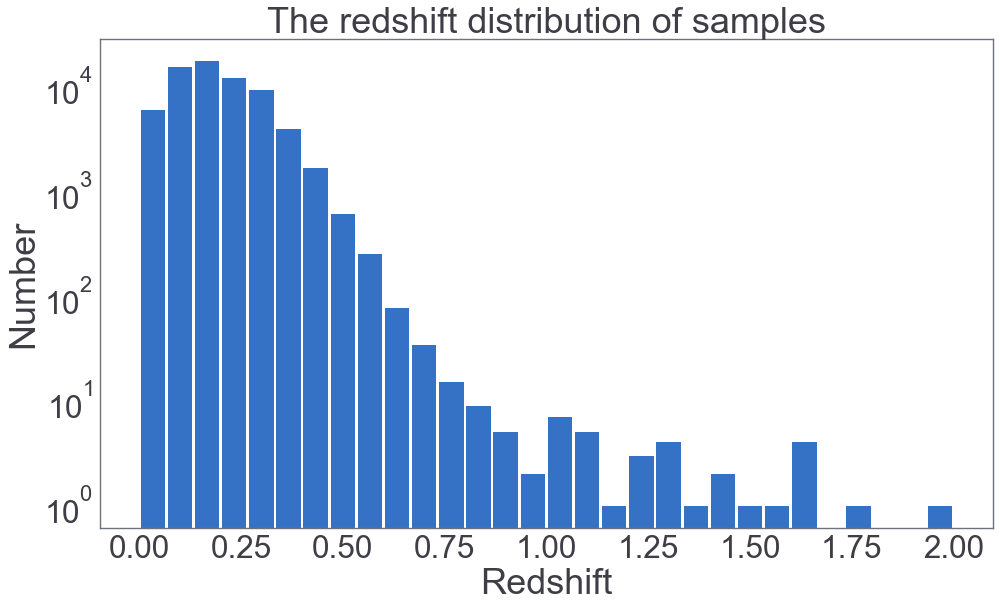

In [4]:

plt.figure(figsize=(16, 9))
plt.hist(DATA_GAMA_FLUX['Z_TONRY'], range=[0, 2], bins=30,  rwidth=0.9)
print('# of samples = %s'%(len(DATA_GAMA_FLUX['Z_TONRY'])))
plt.xlabel('Redshift')
plt.ylabel('Number')
plt.yscale('log')
plt.title('The redshift distribution of samples')


## Color-color plot (NUV-r and r-K)

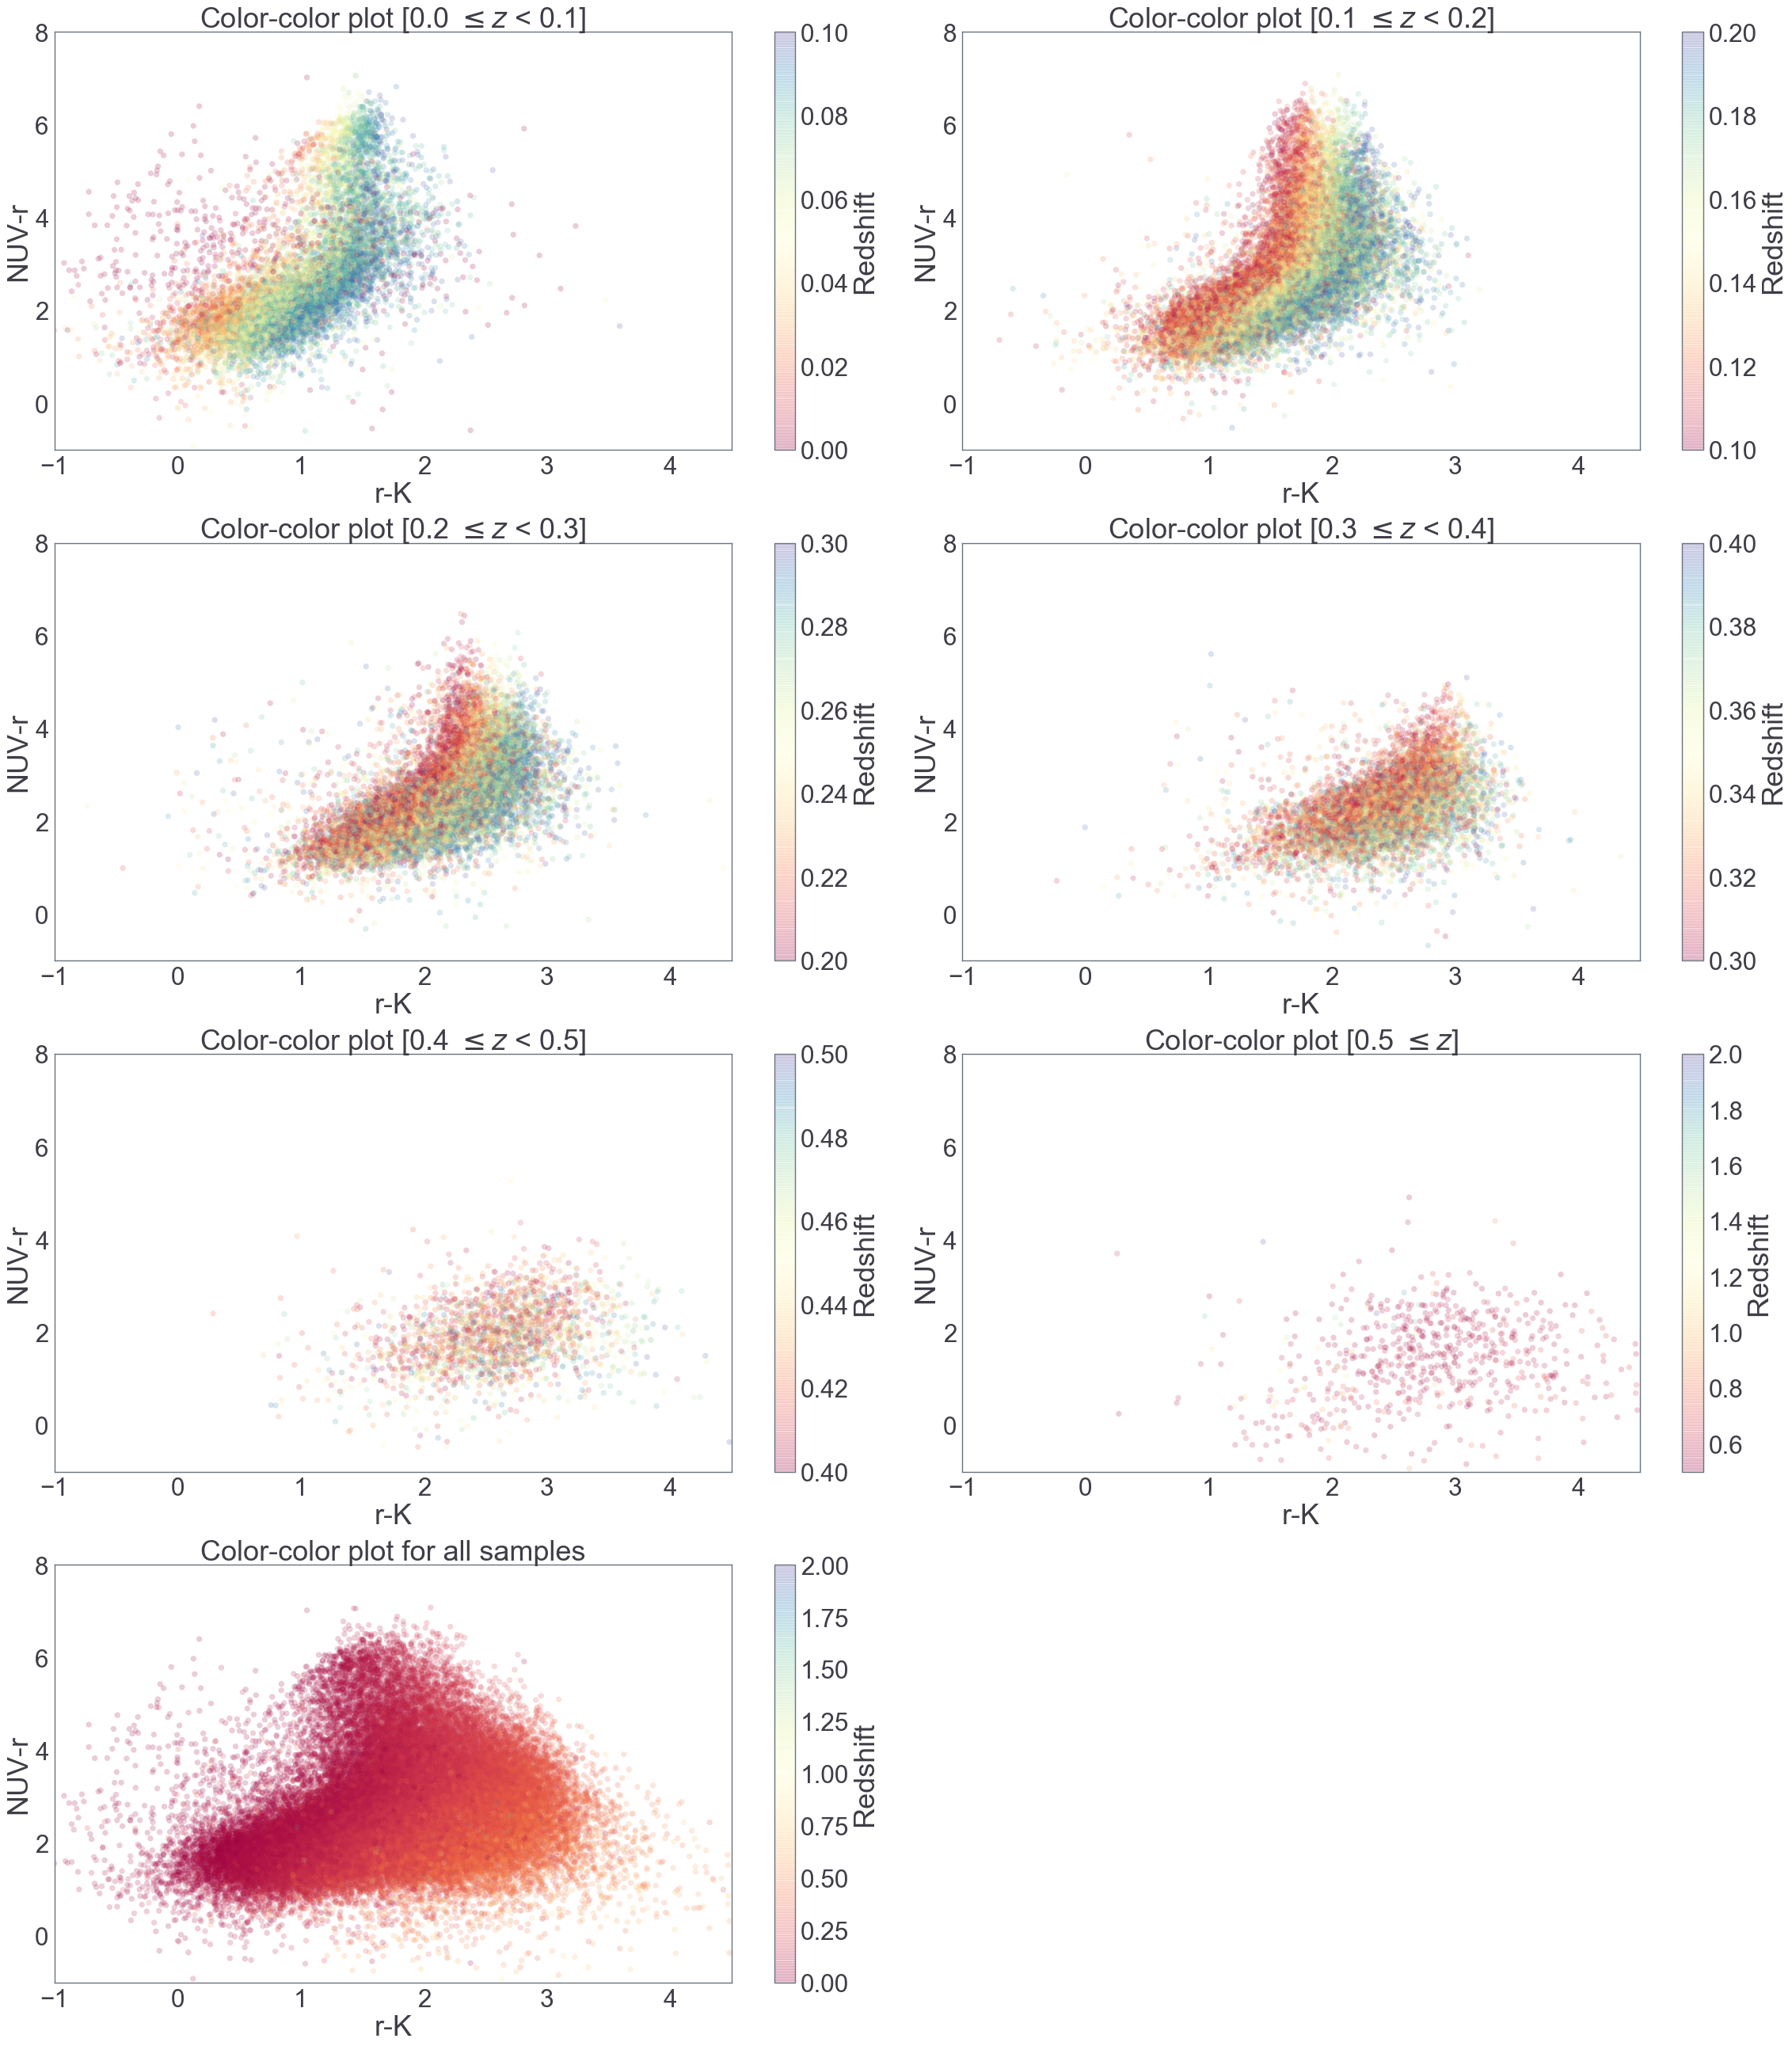

In [5]:
#  Color-color plot with colorbars based on redshift
plt.figure(figsize=(32, 36))
for i in tnrange(6):
    if i <= 4:
        plt.subplot(421 + i)
        z_range = (DATA_GAMA_FLUX['Z_TONRY'] >= 0.1 * i) & (DATA_GAMA_FLUX['Z_TONRY'] < (0.1 * i) + 0.1)
        x = DATA_GAMA_FLUX['R-K'].loc[z_range]
        y = DATA_GAMA_FLUX['NUV-R'].loc[z_range]
        c_z = DATA_GAMA_FLUX['Z_TONRY'].loc[z_range]
        plt.scatter(x, y, c=c_z, alpha=0.2, cmap=plt.cm.Spectral)
        cbar = plt.colorbar()  
        cbar.set_label('Redshift')
        plt.clim(vmin=(0.1 * i), vmax=(0.1 * i) + 0.1)
        plt.xlabel('r-K')
        plt.xlim([-1, 4.5])
        plt.ylabel('NUV-r')
        plt.ylim([-1, 8])
        plt.title(r'Color-color plot [%s $\leq z$ < %s]'%('{:.1f}'.format((0.1 * i)), '{:.1f}'.format((0.1 * i) + 0.1)))
    else:
        plt.subplot(421 + i)
        z_range = (DATA_GAMA_FLUX['Z_TONRY'] >= 0.1 * i)
        x = DATA_GAMA_FLUX['R-K'].loc[z_range]
        y = DATA_GAMA_FLUX['NUV-R'].loc[z_range]
        c_z = DATA_GAMA_FLUX['Z_TONRY'].loc[z_range]
        plt.scatter(x, y, c=c_z, alpha=0.2, cmap=plt.cm.Spectral)
        cbar = plt.colorbar()  
        cbar.set_label('Redshift')
        plt.clim(vmin=(0.1 * i), vmax=2)
        plt.xlabel('r-K')
        plt.xlim([-1, 4.5])
        plt.ylabel('NUV-r')
        plt.ylim([-1, 8])
        plt.title(r'Color-color plot [%s $\leq z$]'%('{:.1f}'.format(0.1 * i)))
plt.subplot(427)
x = DATA_GAMA_FLUX['R-K']
y = DATA_GAMA_FLUX['NUV-R']
plt.scatter(x, y, c=DATA_GAMA_FLUX['Z_TONRY'], alpha=0.2, cmap=plt.cm.Spectral)
cbar = plt.colorbar()  
cbar.set_label('Redshift')
plt.clim(vmin=0, vmax=2)
plt.xlabel('r-K')
plt.xlim([-1, 4.5])
plt.ylabel('NUV-r')
plt.ylim([-1, 8])
plt.title('Color-color plot for all samples')
plt.tight_layout()

# Variational Bayesian Gaussian Mixture (VBGMM) for the classification

In [6]:
# Select columns for classification and manifold learning
data_for_manifoldlearning = DATA_GAMA_FLUX[['Z_TONRY', 'FUV_flux_kcorrected', 'NUV_flux_kcorrected',
                                            'U_flux_kcorrected', 'G_flux_kcorrected', 'R_flux_kcorrected', 'I_flux_kcorrected', 'Z_flux_kcorrected',
                                            'Y_flux_kcorrected', 'J_flux_kcorrected', 'H_flux_kcorrected', 'K_flux_kcorrected']]

/usr/local/lib/python3.5/dist-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


<BarContainer object of 12 artists>

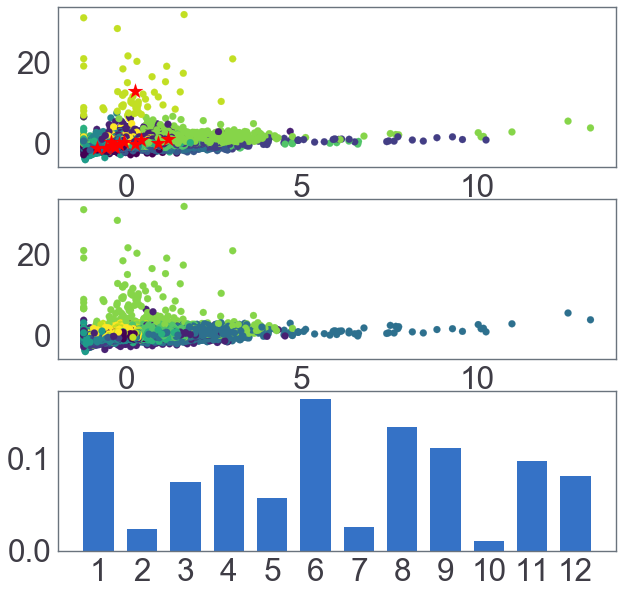

In [7]:

X = data_for_manifoldlearning

# RobustScaler uses [0.25, 0.75] samples
#sc=preprocessing.StandardScaler()
sc=preprocessing.RobustScaler()
sc.fit(X)
X_norm=sc.transform(X)

plt.figure(figsize=(10,10))
x=X_norm[:,0]
y=X_norm[:,1]

#Execute the K-means
km=cluster.KMeans(n_clusters=12)
z_km=km.fit(X_norm)

# Plot the K-means result
plt.subplot(311)
plt.scatter(x,y, c=z_km.labels_)
plt.scatter(z_km.cluster_centers_[:,0],z_km.cluster_centers_[:,1],s=250, marker='*',c='red')

# Execute the VBGMM
vbgm = mixture.BayesianGaussianMixture(n_components=12)
vbgm=vbgm.fit(X_norm)
labels=vbgm.predict(X_norm)

# Plot the VBGMM result
plt.subplot(312)
plt.scatter(x,y, c=labels)

# Plot the probability distribution calculated by VBGMM
#print(vbgm.weights_)
plt.subplot(313)
x_tick =np.array([1,2,3,4,5,6,7,8,9,10,11,12])
plt.bar(x_tick, vbgm.weights_, width=0.7, tick_label=x_tick)


In [8]:
# Add the label from VBGMM to the original pd.DataFrame
data_for_manifoldlearning = data_for_manifoldlearning.join(pd.DataFrame(labels, index=data_for_manifoldlearning.index, columns=['label']))
DATA_GAMA_FLUX = DATA_GAMA_FLUX.join(pd.DataFrame(labels, index=data_for_manifoldlearning.index, columns=['label']))

In [ ]:
# How many clusters are the best for K-means?
distortions = []

for i in tnrange(1,15):
    km = cluster.KMeans(n_clusters=i,
                        init='k-means++',
                        n_init=10,
                        max_iter=300)
    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1,15),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [ ]:
# Show the color-color plot with labels (each number on the plot shows the label number)

plt.figure(figsize=(16, 9))
x = DATA_GAMA_FLUX['R-K']
y = DATA_GAMA_FLUX['NUV-R']
plt.scatter(x, y, c=DATA_GAMA_FLUX['label'], alpha=0.2, cmap=plt.cm.Spectral)
cbar = plt.colorbar()  
cbar.set_label('Label')
plt.clim(vmin=0, vmax=12)
plt.xlabel('r-K')
plt.xlim([-1, 4.5])
plt.ylabel('NUV-r')
plt.ylim([-1, 8])

for i in tnrange(12):
    x_mean = np.mean(DATA_GAMA_FLUX.loc[DATA_GAMA_FLUX['label'] == i, 'R-K'])
    y_mean = np.mean(DATA_GAMA_FLUX.loc[DATA_GAMA_FLUX['label'] == i, 'NUV-R'])
    print('label:%s, center_point=(%s, %s)'%(i, x_mean, y_mean))
    print('# of samples : %s'%(len(DATA_GAMA_FLUX.loc[DATA_GAMA_FLUX['label'] == i])))
    plt.text(x_mean, y_mean, '$%s$'%(i), fontweight='heavy', backgroundcolor='black', fontsize=len(DATA_GAMA_FLUX.loc[DATA_GAMA_FLUX['label'] == i])/200, color=plt.cm.Spectral(i/11))
    

In [ ]:
#  Color-color plot with colorbars based on redshift
plt.figure(figsize=(32, 36))
for i in tnrange(6):
    if i <= 4:
        plt.subplot(421 + i)
        z_range = (DATA_GAMA_FLUX['Z_TONRY'] >= 0.1 * i) & (DATA_GAMA_FLUX['Z_TONRY'] < (0.1 * i) + 0.1)
        x = DATA_GAMA_FLUX['R-K'].loc[z_range]
        y = DATA_GAMA_FLUX['NUV-R'].loc[z_range]
        c_z = DATA_GAMA_FLUX['label'].loc[z_range]
        plt.scatter(x, y, c=c_z, alpha=0.2, cmap=plt.cm.Spectral)
        cbar = plt.colorbar()  
        cbar.set_label('Label')
        plt.clim(vmin=0, vmax=12)
        plt.xlabel('r-K')
        plt.xlim([-1, 4.5])
        plt.ylabel('NUV-r')
        plt.ylim([-1, 8])
        plt.title(r'Color-color plot [%s $\leq z$ < %s]'%('{:.1f}'.format((0.1 * i)), '{:.1f}'.format((0.1 * i) + 0.1)))
        for j in range(12):
            x_mean = np.mean(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'R-K'])
            y_mean = np.mean(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'NUV-R'])
            #print('label:%s, center_point=(%s, %s)'%(j, x_mean, y_mean))
            #print('# of samples : %s'%(len(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j)])))
            if not np.isnan(x_mean):
                plt.text(x_mean, y_mean, '$%s$'%(j), fontweight='heavy', backgroundcolor='black', fontsize=len(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j)])/200, color=plt.cm.Spectral(j/11))
    else:
        plt.subplot(421 + i)
        z_range = (DATA_GAMA_FLUX['Z_TONRY'] >= 0.1 * i)
        x = DATA_GAMA_FLUX['R-K'].loc[z_range]
        y = DATA_GAMA_FLUX['NUV-R'].loc[z_range]
        c_z = DATA_GAMA_FLUX['label'].loc[z_range]
        plt.scatter(x, y, c=c_z, alpha=0.2, cmap=plt.cm.Spectral)
        cbar = plt.colorbar()  
        cbar.set_label('Label')
        plt.clim(vmin=0, vmax=12)
        plt.xlabel('r-K')
        plt.xlim([-1, 4.5])
        plt.ylabel('NUV-r')
        plt.ylim([-1, 8])
        plt.title(r'Color-color plot [%s $\leq z$]'%('{:.1f}'.format(0.1 * i)))
        for j in range(12):
            x_mean = np.mean(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'R-K'])
            y_mean = np.mean(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j), 'NUV-R'])
            #print('label:%s, center_point=(%s, %s)'%(j, x_mean, y_mean))
            #print('# of samples : %s'%(len(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j)])))
            if not np.isnan(x_mean):
                plt.text(x_mean, y_mean, '$%s$'%(j), fontweight='heavy', backgroundcolor='black', fontsize=len(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j)])/200, color=plt.cm.Spectral(j/11))
plt.subplot(427)
x = DATA_GAMA_FLUX['R-K']
y = DATA_GAMA_FLUX['NUV-R']
plt.scatter(x, y, c=DATA_GAMA_FLUX['label'], alpha=0.2, cmap=plt.cm.Spectral)
cbar = plt.colorbar()  
cbar.set_label('Label')
plt.clim(vmin=0, vmax=12)
plt.xlabel('r-K')
plt.xlim([-1, 4.5])
plt.ylabel('NUV-r')
plt.ylim([-1, 8])
plt.title('Color-color plot for all samples')
for j in range(12):
    x_mean = np.mean(DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['label'] == j), 'R-K'])
    y_mean = np.mean(DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['label'] == j), 'NUV-R'])
    #print('label:%s, center_point=(%s, %s)'%(j, x_mean, y_mean))
    #print('# of samples : %s'%(len(DATA_GAMA_FLUX.loc[z_range & (DATA_GAMA_FLUX['label'] == j)])))
    if not np.isnan(x_mean):
        plt.text(x_mean, y_mean, '$%s$'%(j), fontweight='heavy', backgroundcolor='black', fontsize=len(DATA_GAMA_FLUX.loc[(DATA_GAMA_FLUX['label'] == j)])/200, color=plt.cm.Spectral(j/11))
plt.tight_layout()

In [ ]:
'''
n_components = 2
nparray_data_for_manifoldlearning = data_for_manifoldlearning.values
X = nparray_data_for_manifoldlearning
fig = plt.figure(figsize=(32, 27))

for i in tnrange(6):
    n_neighbors = i+10
    
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method='standard').fit_transform(X)
    t1 = time()
    ax = fig.add_subplot(321+i)
    ax.scatter(Y[:, 0], Y[:, 1], alpha=0.2, c=data_for_manifoldlearning['label'], cmap=plt.cm.Spectral)
    ax.set_title("Manifold Learning (LLE) with %i neighbors (%.2g sec)" % (n_neighbors, t1 - t0))
'''